## Forecasting Energy Production Problems with RF Classifier

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [2]:
df = pd.read_csv('../data/interim/filled_for_forecasting.csv', index_col = 0, parse_dates = True)

In [3]:
df.columns

Index(['Shark Meter, KWtotal Kilowatts', 'AE 500kW 1, AC Power Kilowatts',
       'AE 500kW 2, AC Power Kilowatts',
       '(Offline) Weather Station - POA (POA)* Watts/meter²',
       'RECx31 Weather Station, Module Temp Degrees Celsius',
       'RECx31 Weather Station, Ambient Temp Degrees Celsius',
       'AE 500kW 1, PV current Amps', 'AE 500kW 2, PV current Amps',
       'AE 500kW 1, PV voltage Volts', 'AE 500kW 2, PV voltage Volts'],
      dtype='object')

In [39]:
# First we need to get hourly energy in KWH
energy_hourly = df[['AE 500kW 1, AC Power Kilowatts','AE 500kW 2, AC Power Kilowatts']].resample('H').sum()*.25
energy_hourly.columns=['AE 500kW 1, KWH','AE 500kW 2, KWH']

# Then we need to get daily energy in KHW
energy_daily = energy_hourly.resample('D').sum()

# Now calculate the difference
energy_daily['Difference'] = energy_daily['AE 500kW 1, KWH'] - energy_daily['AE 500kW 2, KWH']

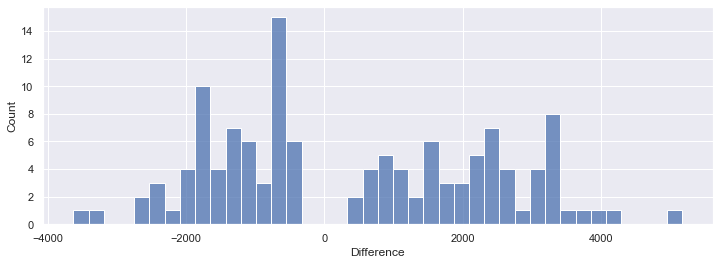

In [42]:
plt.subplots(figsize=(12,4))
sns.histplot(data=energy_daily['Difference'][abs(energy_daily['Difference'])>500], bins=40);

In [103]:
(abs(energy_daily['Difference'])>100).sum()

455

In [73]:
455/1919

0.23710265763418448

In [48]:
energy_daily[abs(energy_daily['Difference'])>400].head(30)

,"AE 500kW 1, KWH","AE 500kW 2, KWH",Difference
Site Time,,,
2015-10-11,3196.71400,105.34850,3091.36550
2015-10-12,3174.80200,175.75000,2999.05200
2015-10-15,3132.90300,2697.66100,435.24200
2015-10-16,2991.21825,2368.11750,623.10075
2015-10-19,3243.47175,2746.49825,496.97350
2015-10-20,2825.24025,2400.30975,424.93050
2015-10-21,2653.79700,2244.77050,409.02650
2015-10-23,3202.37150,2709.42100,492.95050
2015-10-30,2800.37750,2374.92675,425.45075


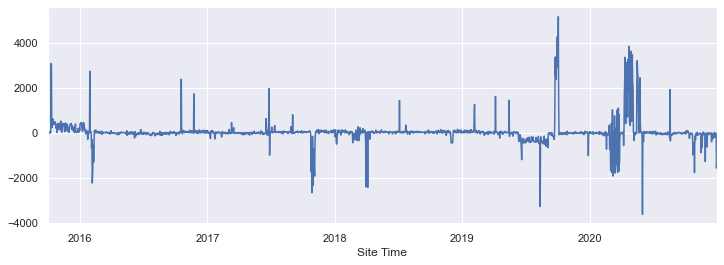

In [50]:
energy_daily['Difference'].plot(figsize=(12,4));

In [51]:
energy_daily['Difference'].std()

528.9202276282263

In [52]:
energy_daily['Difference'].mean()

30.90826094319959

In [62]:
upper_bound = energy_daily['Difference'].mean() + energy_daily['Difference'].std()
lower_bound = energy_daily['Difference'].mean() - energy_daily['Difference'].std()
print((energy_daily['Difference']>upper_bound).sum())
print((energy_daily['Difference']<lower_bound).sum())

61
64


We have 125 instances when the daily difference in energy produced by the two inverters was more than one standard deviation away from the mean.  

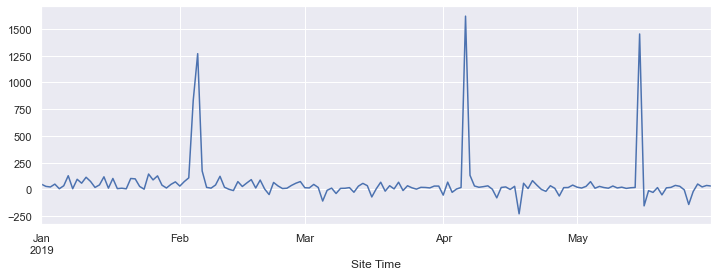

In [66]:
energy_daily['Difference'].loc['2019-01':'2019-05'].plot(figsize=(12,4));

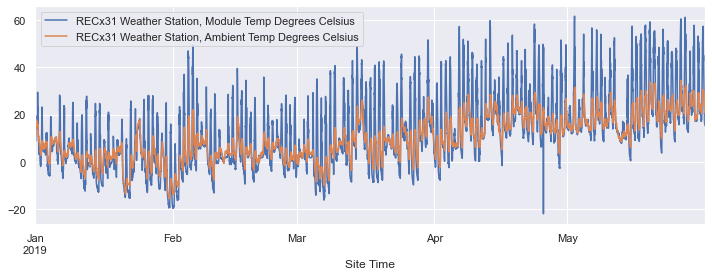

In [71]:
df[['RECx31 Weather Station, Module Temp Degrees Celsius',\
       'RECx31 Weather Station, Ambient Temp Degrees Celsius']].loc['2019-01':'2019-05'].plot(figsize=(12,4));

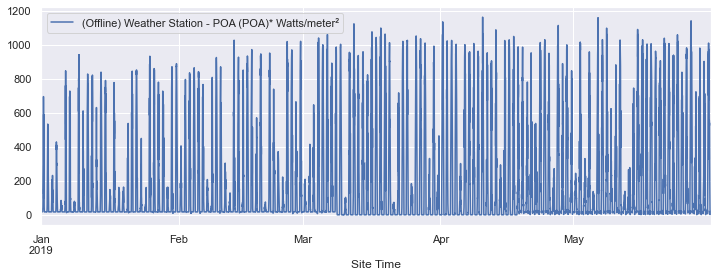

In [69]:
df[['(Offline) Weather Station - POA (POA)* Watts/meter²']].loc['2019-01':'2019-05'].plot(figsize=(12,4));

In [74]:
energy_daily['Max Module Temp'] = df['RECx31 Weather Station, Module Temp Degrees Celsius'].resample('D').max()

In [75]:
energy_daily['Max Ambient Temp'] = df['RECx31 Weather Station, Ambient Temp Degrees Celsius'].resample('D').max()

In [88]:
energy_daily['Diff_1'] = energy_daily['Difference'].shift(1)
energy_daily['Diff_2'] = energy_daily['Difference'].shift(2)
energy_daily['Diff_3'] = energy_daily['Difference'].shift(3)
energy_daily['Diff_4'] = energy_daily['Difference'].shift(4)
energy_daily['Diff_5'] = energy_daily['Difference'].shift(5)
energy_daily['Diff_6'] = energy_daily['Difference'].shift(6)
energy_daily['Diff_7'] = energy_daily['Difference'].shift(7)

In [91]:
energy_daily.columns

Index(['AE 500kW 1, KWH', 'AE 500kW 2, KWH', 'Difference', 'Max Module Temp',
       'Max Ambient Temp', 'Diff_1', 'Diff_2', 'Diff_3', 'Diff_4', 'Diff_5',
       'Diff_6', 'Diff_7'],
      dtype='object')

In [92]:
energy_daily['MMT_1'] = energy_daily['Max Module Temp'].shift(1)
energy_daily['MMT_2'] = energy_daily['Max Module Temp'].shift(2)
energy_daily['MMT_3'] = energy_daily['Max Module Temp'].shift(3)
energy_daily['MMT_4'] = energy_daily['Max Module Temp'].shift(4)
energy_daily['MMT_5'] = energy_daily['Max Module Temp'].shift(5)
energy_daily['MMT_6'] = energy_daily['Max Module Temp'].shift(6)
energy_daily['MMT_7'] = energy_daily['Max Module Temp'].shift(7)

In [93]:
energy_daily['MAT_1'] = energy_daily['Max Ambient Temp'].shift(1)
energy_daily['MAT_2'] = energy_daily['Max Ambient Temp'].shift(2)
energy_daily['MAT_3'] = energy_daily['Max Ambient Temp'].shift(3)
energy_daily['MAT_4'] = energy_daily['Max Ambient Temp'].shift(4)
energy_daily['MAT_5'] = energy_daily['Max Ambient Temp'].shift(5)
energy_daily['MAT_6'] = energy_daily['Max Ambient Temp'].shift(6)
energy_daily['MAT_7'] = energy_daily['Max Ambient Temp'].shift(7)

In [115]:
energy_daily.dropna(inplace=True)

In [116]:
energy_daily.columns

Index(['AE 500kW 1, KWH', 'AE 500kW 2, KWH', 'Difference', 'Max Module Temp',
       'Max Ambient Temp', 'Diff_1', 'Diff_2', 'Diff_3', 'Diff_4', 'Diff_5',
       'Diff_6', 'Diff_7', 'MMT_1', 'MMT_2', 'MMT_3', 'MMT_4', 'MMT_5',
       'MMT_6', 'MMT_7', 'MAT_1', 'MAT_2', 'MAT_3', 'MAT_4', 'MAT_5', 'MAT_6',
       'MAT_7'],
      dtype='object')

In [117]:
X = energy_daily[['Diff_1', 'Diff_2', 'Diff_3', 'Diff_4', 'Diff_5','Diff_6', 'Diff_7',\
        'MMT_1', 'MMT_2', 'MMT_3', 'MMT_4', 'MMT_5','MMT_6', 'MMT_7', \
        'MAT_1', 'MAT_2', 'MAT_3', 'MAT_4', 'MAT_5', 'MAT_6','MAT_7']]

In [118]:
y = (abs(energy_daily['Difference'])>400)

In [119]:
y.sum(), y.shape

(186, (1912,))

In [131]:
X_train=X.loc[:'2019']
X_test = X.loc['2020':]
y_train=y.loc[:'2019']
y_test = y.loc['2020':]

In [132]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [133]:
y_pred = rf.predict(X_test)

In [136]:
print("\nConfusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("\nAccuracy: \n", accuracy_score(y_test, y_pred))


Confusion Matrix: 
 [[280  10]
 [ 53  23]]

Accuracy: 
 0.8278688524590164


In [137]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = list(X_train.columns), \
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)


        importance
Diff_1    0.161328
Diff_2    0.086095
Diff_4    0.074068
Diff_3    0.068880
Diff_5    0.064555
Diff_6    0.046339
Diff_7    0.045775
MMT_7     0.041560
MMT_3     0.034509
MAT_5     0.033926
MMT_1     0.033741
MAT_7     0.033474
MAT_6     0.033130
MAT_4     0.032450
MMT_6     0.031538
MMT_5     0.031492
MAT_2     0.030749
MAT_1     0.030148
MMT_4     0.030066
MMT_2     0.028912
MAT_3     0.027266
